In [2]:
!pip install easyocr
!pip install ipywidgets
!pip install paddleocr paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 

# Comparison

This notebook compares two OCR models—**EasyOCR** and **PaddleOCR**—for recognizing text on vehicle license plates.  

**Workflow:**  
1. **Preprocessing:** Resize, adjust contrast/brightness, apply CLAHE, blur, threshold, and optional morphology to enhance the plate.  
2. **Horizontal Stretching:** Improve character separation for OCR.  
3. **OCR Comparison:** Extract text and confidence scores from both EasyOCR and PaddleOCR to evaluate performance on the same preprocessed plate images.  

The focus is on understanding how preprocessing affects each model and comparing their detection accuracy.# Новый раздел

## Preprocessing


### Interactive setting

In [16]:
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Checkbox
import cv2
import numpy as np
from matplotlib import pyplot as plt

# ==== LOAD IMAGE ====
# change the path to your own photo
img = cv2.imread('/content/30587820.jpeg')
if img is None:
    raise ValueError("Failed to open 'plate.jpg' — check the file path")

# convert to grayscale
gray_orig = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def process(
    # scale
    scale=2.0,
    # brightness/contrast
    alpha=1.0,  # contrast
    beta=0,     # brightness
    # smoothing
    blur_type='bilateral',
    blur_ksize=3,
    # CLAHE (local contrast enhancement)
    use_clahe=False,
    clahe_clip=2,
    clahe_grid=8,
    # thresholding
    thr_method='adaptive',
    block=31,
    C=9,
    global_thr=128,
    # morphology
    morph_op='none',
    morph_ksize=3,
    morph_iter=1,
    # inversion
    invert=False
):
    # sanitize parameters
    blur_ksize  = max(1, int(blur_ksize) | 1)
    block       = max(3, int(block) | 1)
    morph_ksize = max(1, int(morph_ksize) | 1)
    morph_iter  = max(1, int(morph_iter))

    # 1) scaling
    gray = cv2.resize(
        gray_orig,
        None,
        fx=scale,
        fy=scale,
        interpolation=cv2.INTER_CUBIC
    )

    # 2) brightness/contrast: new = alpha*gray + beta
    gray = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)

    # 3) smoothing
    if blur_type == 'gaussian':
        gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    elif blur_type == 'median':
        gray = cv2.medianBlur(gray, blur_ksize)
    elif blur_type == 'bilateral':
        gray = cv2.bilateralFilter(gray, blur_ksize, 75, 75)
    # 'none' — no smoothing

    # 4) CLAHE (local contrast enhancement)
    if use_clahe:
        clahe = cv2.createCLAHE(
            clipLimit=float(clahe_clip),
            tileGridSize=(int(clahe_grid), int(clahe_grid))
        )
        gray = clahe.apply(gray)

    # 5) thresholding
    if thr_method == 'adaptive':
        th = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            block, int(C)
        )
    elif thr_method == 'otsu':
        _, th = cv2.threshold(
            gray, 0, 255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    elif thr_method == 'global':
        _, th = cv2.threshold(gray, int(global_thr), 255, cv2.THRESH_BINARY)
    else:  # 'none'
        th = gray.copy()

    # 6) morphology
    if morph_op != 'none':
        kernel = np.ones((morph_ksize, morph_ksize), np.uint8)
        if morph_op == 'erode':
            th = cv2.erode(th, kernel, iterations=morph_iter)
        elif morph_op == 'dilate':
            th = cv2.dilate(th, kernel, iterations=morph_iter)
        elif morph_op == 'open':
            th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=morph_iter)
        elif morph_op == 'close':
            th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=morph_iter)

    # 7) inversion
    if invert:
        th = cv2.bitwise_not(th)

    # display the result
    plt.figure(figsize=(5,5))
    plt.imshow(th, cmap='gray')
    plt.axis('off')
    plt.show()

    # optionally, save the current result:
    # cv2.imwrite('current_preprocessed.png', th)

interact(
    process,
    # scale
    scale=FloatSlider(min=1.0, max=5.0, step=0.2, value=2.0, description='Scale'),
    # brightness/contrast
    alpha=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.0, description='Contrast α'),
    beta=IntSlider(min=-100, max=100, step=5, value=0, description='Brightness β'),
    # smoothing
    blur_type=Dropdown(options=['none', 'gaussian', 'median', 'bilateral'],
                       value='bilateral', description='Blur type'),
    blur_ksize=IntSlider(min=1, max=15, step=2, value=3, description='Blur k'),
    # CLAHE
    use_clahe=Checkbox(value=False, description='Use CLAHE'),
    clahe_clip=FloatSlider(min=1, max=8, step=0.5, value=2, description='CLAHE clip'),
    clahe_grid=IntSlider(min=4, max=32, step=2, value=8, description='CLAHE grid'),
    # thresholding
    thr_method=Dropdown(options=['adaptive', 'otsu', 'global', 'none'],
                        value='adaptive', description='Thresh'),
    block=IntSlider(min=3, max=71, step=2, value=31, description='Block'),
    C=IntSlider(min=0, max=20, step=1, value=9, description='C'),
    global_thr=IntSlider(min=0, max=255, step=5, value=128, description='Global thr'),
    # morphology
    morph_op=Dropdown(options=['none', 'erode', 'dilate', 'open', 'close'],
                      value='none', description='Morph'),
    morph_ksize=IntSlider(min=1, max=15, step=2, value=3, description='Morph k'),
    morph_iter=IntSlider(min=1, max=5, step=1, value=1, description='Morph iter'),
    # inversion
    invert=Checkbox(value=False, description='Invert')
)


interactive(children=(FloatSlider(value=2.0, description='Scale', max=5.0, min=1.0, step=0.2), FloatSlider(val…

<function __main__.process(scale=2.0, alpha=1.0, beta=0, blur_type='bilateral', blur_ksize=3, use_clahe=False, clahe_clip=2, clahe_grid=8, thr_method='adaptive', block=31, C=9, global_thr=128, morph_op='none', morph_ksize=3, morph_iter=1, invert=False)>

### Static setting

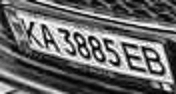

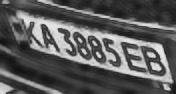

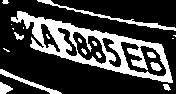

In [5]:
import cv2
import numpy as np

plate = cv2.imread("/content/30587820.jpeg")

if plate is None:
    raise ValueError("ErrorPath or no photo")

gray, proc, thr = preprocess_plate(
    plate,
    scale=2.0,
    alpha=1.5,
    beta=-100,
    blur_type="bilateral",
    blur_k=11,
    use_clahe=True,
    clahe_clip=2.0,
    clahe_grid=8,
    thresh_mode="otsu",
    morph_mode="none",
    invert=False,
)

from google.colab.patches import cv2_imshow
cv2_imshow(gray)
cv2_imshow(proc)
if thr is not None:
    cv2_imshow(thr)

### Stretching horizontally

In [7]:
def stretch_horizontal(last_preprocessed_img, scale=1.5):
    """
    Stretches the input image horizontally by the given scale factor.

    Parameters:
        last_preprocessed_img (numpy.ndarray): Input image.
        scale (float): Horizontal stretch factor (default: 1.5).

    Returns:
        numpy.ndarray: Horizontally stretched image.
    """
    if last_preprocessed_img is None:
        raise ValueError("Input image is None.")

    height, width = last_preprocessed_img.shape[:2]
    new_width = int(width * scale)

    # Resize only width
    stretched_img = cv2.resize(
        last_preprocessed_img,
        (new_width, height),
        interpolation=cv2.INTER_LINEAR
    )

    return stretched_img

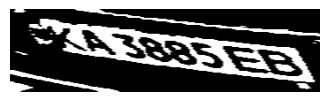

In [9]:
from matplotlib import pyplot as plt

stretched = stretch_horizontal(thr, 2)
plt.figure(figsize=(4,4))
plt.imshow(stretched, cmap='gray')
plt.axis('off')
plt.show()

## Processing

### EasyOCR

In [10]:
import easyocr
from matplotlib import pyplot as plt

def easyocr_process_with_positions(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    reader = easyocr.Reader(['en'])
    result = reader.readtext(image, detail=1)
    extracted = []

    for bbox, text, prob in result:
        print(f"Detected text: '{text}' | Confidence: {prob:.3f}")
        # bbox: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
        x_min = min([p[0] for p in bbox])
        x_max = max([p[0] for p in bbox])
        y_min = min([p[1] for p in bbox])
        y_max = max([p[1] for p in bbox])

        # Split the bounding box horizontally per character
        char_width = (x_max - x_min) / max(len(text), 1)
        for i, ch in enumerate(text):
            char_x_min = x_min + i * char_width
            char_x_max = char_x_min + char_width
            char_info = {
                'char': ch,
                'prob': float(prob),
                'bbox': [char_x_min, y_min, char_x_max, y_max]
            }
            extracted.append(char_info)
            #print(f"  Char: '{ch}' | Prob: {prob:.3f} | BBox: {char_info['bbox']}")


    return extracted

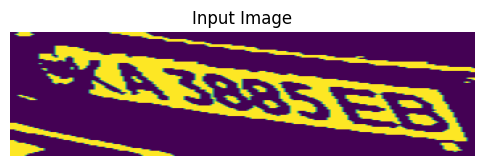

Detected text: '43E3' | Confidence: 0.206


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [12]:
res = easyocr_process_with_positions(stretched)

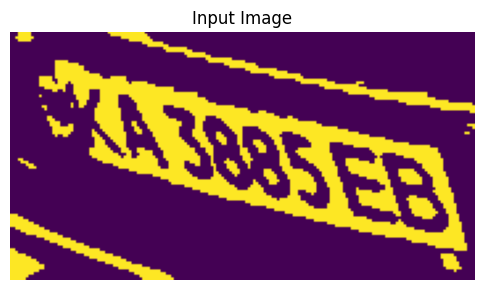

Detected text: 'Eb)' | Confidence: 0.515
Detected text: 'T333s ' | Confidence: 0.013


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [13]:
res = easyocr_process_with_positions(thr)

### PaddleOCR

/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional t

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/766 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/UVDoc`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/735 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.74M [00:00<?, ?B/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_det`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/7.77M [00:00<?, ?B/s]

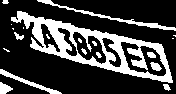

Text: KA3885EB | Conf: 0.9121077060699463


In [14]:
import cv2
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    lang='en',                  # English letters/numbers
    use_textline_orientation=True, # Handle upside-down/tilted text
)

# Load
# img = cv2.imread("/content/30459643.jpeg")

# Optional: convert to grayscale for thresholding
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # Adaptive threshold (good for varying lighting)
# thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#                             cv2.THRESH_BINARY, 15, 10)

# Convert to BGR (PaddleOCR expects 3 channels)
ocr_input = cv2.cvtColor(thr, cv2.COLOR_GRAY2BGR)

cv2_imshow(ocr_input)

result = ocr.predict(ocr_input)

for page in result:
    texts = page.get('rec_texts', [])
    scores = page.get('rec_scores', [])

    for text, score in zip(texts, scores):
        print("Text:", text, "| Conf:", score)

### EasyOCR vs PaddleOCR

**EasyOCR**  
- Accuracy: Good for clear text, but sensitive to blur and noise  
- Speed: Fast  
- Bounding Boxes: Character-level or text-line  
- Best Use Case: Real-time processing with strong preprocessing  

**PaddleOCR**  
- Accuracy: Often more robust to tilt, blur, and low-quality images  
- Speed: Slower (let`s consider GPU)
- Bounding Boxes: Primarily text-line, can detect orientation  
- Best Use Case: Challenging conditions, skewed or blurred plates where latency is not so important

**Tesseract**  
- Accuracy: Very good for clean printed text. Not our use case...


#### Literature:
- In a benchmark on Jetson Nano, PaddleOCR was more accurate and faster than EasyOCR: https://ddd.uab.cat/pub/tfg/2024/tfg_8956384/OCR_Implementation_on_Jetson_Nano.pdf

- https://mljourney.com/paddleocr-vs-tesseract-comprehensive-comparison-for-ocr-implementation

- https://github.com/asanborn/PADDLE
- https://github.com/entbappy/Car-Number-Plates-Detection